# Cài đặt các thư viện cần thiết

In [1]:
import torch
# Đặt seed cho việc tạo số ngẫu nhiên để đảm bảo tính tái lập
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# Cài đặt các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from torch import nn, optim

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn import LGConv

# Đọc bộ dữ liệu, phân chia dữ liệu huấn luyện, đánh giá và kiểm tra mô hình

In [3]:
# Sử dụng pandas để đọc dữ liệu từ file CSV
ratings = pd.read_csv('./dataset/ml-latest-small/ratings.csv')
movies = pd.read_csv('./dataset/ml-latest-small/movies.csv')

In [4]:
# Tạo ánh xạ từ user_id và movie_id trong DataFrame ratings sang các chỉ số duy nhất
user_map = {user_id: i for i, user_id in enumerate(ratings['userId'].unique())}
movie_map = {movie_id: i for i, movie_id in enumerate(ratings['movieId'].unique())}

# Đếm số lượng người dùng và phim trong tập dữ liệu
num_users = len(user_map)
num_movies = len(movie_map)
num_total = num_users + num_movies

In [5]:
# Chuyển đổi user_id và movie_id trong DataFrame ratings sang tensor LongTensor
user_ids = torch.LongTensor([user_map[user_id] for user_id in ratings['userId']])
movie_ids = torch.LongTensor([movie_map[movie_id] for movie_id in ratings['movieId']])
edge_index = torch.stack([user_ids, movie_ids])

In [6]:
# Chia tập dữ liệu thành các phần train, validation và test
train_index, test_index = train_test_split(range(len(ratings)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

In [7]:
# Tách các cạnh (edges) trong đồ thị thành các tập train, validation và test
train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

# Triển khai mô hình và các hàm đánh giá mô hình

In [8]:
# Tạo một batch các chỉ số ngẫu nhiên bằng cách sử dụng np.random.choice
def sample_mini_batch(edge_index):
  index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

  # Tạo các mẫu âm (negative samples)
  edge_index = structured_negative_sampling(edge_index)
  edge_index = torch.stack(edge_index, dim=0)

  user_index = edge_index[0, index]
  pos_movie_index = edge_index[1, index]
  neg_movie_index = edge_index[2, index]

  return user_index, pos_movie_index, neg_movie_index

In [9]:
# LightGCN Model
class LightGCN(nn.Module):
  def __init__(self, num_users, num_movies, num_layers=4, dim_h=64):
    super().__init__()
    self.num_users = num_users 
    self.num_movies = num_movies 
    self.num_layers = num_layers
    self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h) 
    self.emb_movies = nn.Embedding(num_embeddings=self.num_movies, embedding_dim=dim_h)  
    self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

    # Khởi tạo trọng số
    nn.init.normal_(self.emb_users.weight, std=0.01)
    nn.init.normal_(self.emb_movies.weight, std=0.01)

  def forward(self, edge_index):
    # Kết hợp embedding của người dùng và phim
    emb = torch.cat([self.emb_users.weight, self.emb_movies.weight])
    embs = [emb]
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)  # Truyền qua từng lớp LGConv
      embs.append(emb)
    
    # Tính embedding cuối cùng bằng cách lấy trung bình
    emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)
    
    # Tách embedding cuối cùng thành embedding của người dùng và phim
    emb_users_final, emb_movies_final = torch.split(emb_final, [self.num_users, self.num_movies])

    return emb_users_final, self.emb_users.weight, emb_movies_final, self.emb_movies.weight

In [10]:
# Calculate the loss
def bpr_loss(emb_users_final, emb_users, emb_pos_movies_final, emb_pos_movies, emb_neg_movies_final, emb_neg_movies):
  reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                       emb_pos_movies.norm().pow(2) +
                       emb_neg_movies.norm().pow(2))
  pos_ratings = torch.mul(emb_users_final, emb_pos_movies_final).sum(dim=1)
  neg_ratings = torch.mul(emb_users_final, emb_neg_movies_final).sum(dim=1)
  bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
  return -bpr_loss + reg_loss

In [11]:
def get_user_movies(edge_index):
  user_movies = dict()
  for i in range(edge_index.shape[1]):
    user = edge_index[0][i].item()
    item = edge_index[1][i].item()
    if user not in user_movies:
      user_movies[user] = []
    user_movies[user].append(item)
  return user_movies

In [12]:
def compute_recall_at_k(items_ground_truth, items_predicted):
  num_correct_pred = np.sum(items_predicted, axis=1)
  num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

  recall = np.mean(num_correct_pred / num_total_pred)

  return recall

In [13]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
  test_matrix = np.zeros((len(items_predicted), K))

  for i, items in enumerate(items_ground_truth):
    length = min(len(items), K)
    test_matrix[i, :length] = 1
  
  max_r = test_matrix
  idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
  dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
  dcg = np.sum(dcg, axis=1)
  idcg[idcg == 0.] = 1.
  ndcg = dcg / idcg
  ndcg[np.isnan(ndcg)] = 0.
  
  return np.mean(ndcg)

In [14]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

  ratings = torch.matmul(model.emb_users.weight, model.emb_movies.weight.T)

  for exclude_edge_index in exclude_edge_indices:
    user_pos_movies = get_user_movies(exclude_edge_index)
    exclude_users = []
    exclude_movies = []
    for user, items in user_pos_movies.items():
      exclude_users.extend([user] * len(items))
      exclude_movies.extend(items)
    ratings[exclude_users, exclude_movies] = -1024

  # get the top k recommended items for each user
  _, top_K_movies = torch.topk(ratings, k=K)

  # get all unique users in evaluated split
  users = edge_index[0].unique()

  test_user_pos_movies = get_user_movies(edge_index)

  # convert test user pos items dictionary into a list
  test_user_pos_movies_list = [test_user_pos_movies[user.item()] for user in users]

  # determine the correctness of topk predictions
  items_predicted = []
  for user in users:
    ground_truth_movies = test_user_pos_movies[user.item()]
    label = list(map(lambda x: x in ground_truth_movies, top_K_movies[user]))
    items_predicted.append(label)

  recall = compute_recall_at_k(test_user_pos_movies_list, items_predicted)
  ndcg = compute_ndcg_at_k(test_user_pos_movies_list, items_predicted)

  return recall, ndcg

In [15]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
  emb_users_final, emb_users, emb_movies_final, emb_movies = model.forward(edge_index)
  user_indices, pos_movie_indices, neg_movie_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

  emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
  emb_pos_movies_final, emb_pos_movies = emb_movies_final[pos_movie_indices], emb_movies[pos_movie_indices]
  emb_neg_movies_final, emb_neg_movies = emb_movies_final[neg_movie_indices], emb_movies[neg_movie_indices]

  loss = bpr_loss(emb_users_final, emb_users, emb_pos_movies_final, emb_pos_movies, emb_neg_movies_final, emb_neg_movies).item()

  recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

  return loss, recall, ndcg

# Huấn luyện mô hình

In [16]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = LightGCN(num_users, num_movies)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [18]:
num_batch = int(len(train_index) / BATCH_SIZE)
for epoch in range(31):
  model.train()
  for batch in range(num_batch):
    optimizer.zero_grad()

    emb_users_final, emb_users, emb_movies_final, emb_movies = model.forward(train_edge_index)
    
    user_index, pos_movies_index, neg_movies_index = sample_mini_batch(train_edge_index)
    
    emb_users_final, emb_users = emb_users_final[user_index], emb_users[user_index]
    emb_pos_movies_final, emb_pos_movies = emb_movies_final[pos_movies_index], emb_movies_final[pos_movies_index]
    emb_neg_movies_final, emb_neg_movies = emb_movies_final[neg_movies_index], emb_movies_final[neg_movies_index]

    train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_movies_final, emb_pos_movies, emb_neg_movies_final, emb_neg_movies)
    
    train_loss.backward()
    optimizer.step()
  
  model.eval()
  val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
  if 'train_data' in globals():
    new_data = pd.DataFrame({
      'epoch': [epoch],
      'train_loss': [train_loss.item()],
      'val_loss': [val_loss],
      'recall': [recall],
      'ndcg': [ndcg]
    })
    train_data = pd.concat([train_data, new_data], ignore_index=True)
  else:
    train_data = pd.DataFrame({
      'epoch': [epoch],
      'train_loss': [train_loss.item()],
      'val_loss': [val_loss],
      'recall': [recall],
      'ndcg': [ndcg]
    })
  print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}:{recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 0 | Train loss: -0.69723 | Val loss: -0.68993 | Val recall@20:0.10500 | Val ndcg@20: 0.10823
Epoch 1 | Train loss: -0.72033 | Val loss: -0.67477 | Val recall@20:0.10685 | Val ndcg@20: 0.11205
Epoch 2 | Train loss: -0.76183 | Val loss: -0.64450 | Val recall@20:0.10884 | Val ndcg@20: 0.11643
Epoch 3 | Train loss: -0.85335 | Val loss: -0.59855 | Val recall@20:0.11052 | Val ndcg@20: 0.11353
Epoch 4 | Train loss: -1.03444 | Val loss: -0.54025 | Val recall@20:0.11178 | Val ndcg@20: 0.11344
Epoch 5 | Train loss: -1.31896 | Val loss: -0.47597 | Val recall@20:0.10487 | Val ndcg@20: 0.11115
Epoch 6 | Train loss: -1.54481 | Val loss: -0.40555 | Val recall@20:0.11160 | Val ndcg@20: 0.11339
Epoch 7 | Train loss: -2.02372 | Val loss: -0.34625 | Val recall@20:0.10876 | Val ndcg@20: 0.11209
Epoch 8 | Train loss: -2.32553 | Val loss: -0.29417 | Val recall@20:0.10874 | Val ndcg@20: 0.11351
Epoch 9 | Train loss: -2.88420 | Val loss: -0.22430 | Val recall@20:0.11015 | Val ndcg@20: 0.11379
Epoch 10 |

In [19]:
train_data

,epoch,train_loss,val_loss,recall,ndcg
0,0,-0.697230,-0.689928,0.105001,0.108234
1,1,-0.720334,-0.674775,0.106849,0.112054
2,2,-0.761827,-0.644503,0.108836,0.116427
3,3,-0.853347,-0.598552,0.110519,0.113530
4,4,-1.034439,-0.540254,0.111781,0.113441
5,5,-1.318955,-0.475973,0.104867,0.111149
6,6,-1.544815,-0.405547,0.111605,0.113390
7,7,-2.023716,-0.346250,0.108758,0.112086
8,8,-2.325532,-0.294167,0.108737,0.113509
9,9,-2.884201,-0.224298,0.110149,0.113789


In [20]:
train_data.to_csv('./training/train_data.csv', index=False)

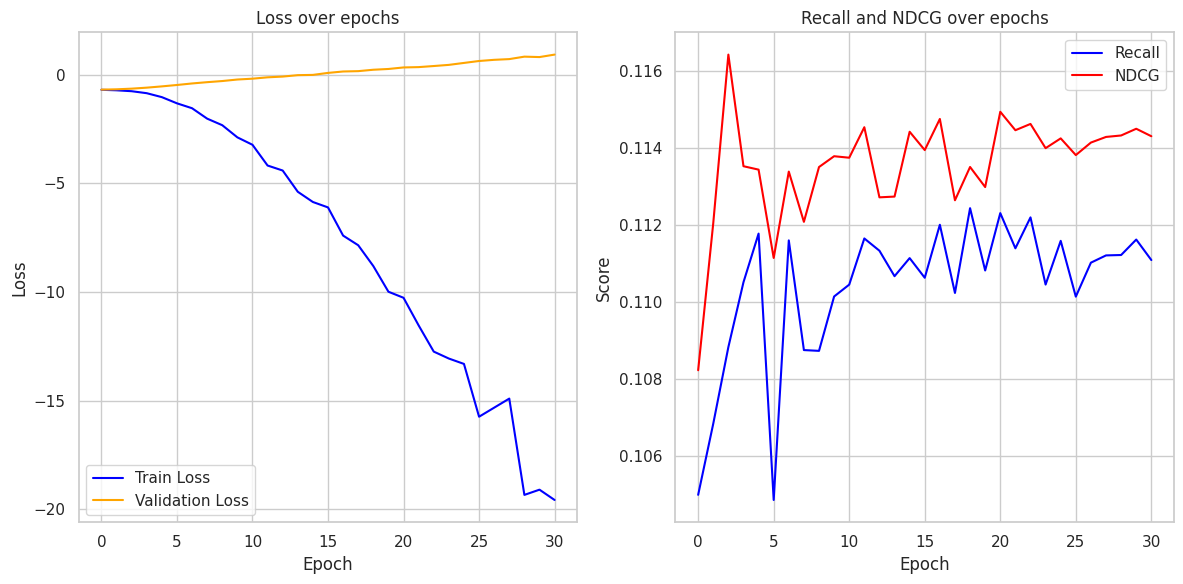

In [21]:
# Trực quan hóa kết quả huấn luyện trong file train_data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_data['epoch'], train_data['train_loss'], label='Train Loss', color='blue')
plt.plot(train_data['epoch'], train_data['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_data['epoch'], train_data['recall'], label='Recall', color='blue')
plt.plot(train_data['epoch'], train_data['ndcg'], label='NDCG', color='red')
plt.title('Recall and NDCG over epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.savefig('./training/loss_recall_ndcg.png')

In [22]:
# Lưu model đã huấn luyện
torch.save(model.state_dict(), './model/lightgcn_model.pth')
# Lưu các tham số của model
torch.save(model, './model/lightgcn_model_full.pth')

In [23]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])
print(f"Test loss: {test_loss:.5f} | Test recall@{K}:{test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 2.85709 | Test recall@20:0.12092 | Test ndcg@20: 0.12556


# Khai báo hàm đề xuất phim

In [24]:
movies_df = pd.read_csv('./dataset/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('./dataset/ml-latest-small/ratings.csv')

In [25]:
movieid_title = pd.Series(movies_df['title'].values, index=movies_df['movieId']).to_dict()
movieid_genres = pd.Series(movies_df['genres'].values, index=movies_df['movieId']).to_dict()

In [26]:
user_pos_movies = get_user_movies(edge_index)

In [27]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

def recommend(user_id, num_recs):
  # user_id = str(user_id)
  user = user_map[user_id]
  emb_user = model.emb_users.weight[user]
  ratings = model.emb_movies.weight @ emb_user

  values, indices = torch.topk(ratings, k=100)
  
  # Các phim đã được người dùng đánh giá
  ids = [index.cpu().item() for index in indices if index in user_pos_movies[user]][:num_recs]
  # ids = [index.cpu().item() for index in indices if index in user_pos_movies[user]]
  movieids = [list(movie_map.keys())[list(movie_map.values()).index(movie)] for movie in ids]
  titles = [movieid_title[id] for id in movieids]
  genres = [movieid_genres[id] for id in movieids]

  print(f'Phim đã được người dùng {user_id} đánh giá:')
  for i in range(len(movieids)):
    print(f'- {titles[i]}, thể loại: {genres[i]}')

  ids = [index.cpu().item() for index in indices if index not in user_pos_movies[user]][:num_recs]
  movieids = [list(movie_map.keys())[list(movie_map.values()).index(book)] for book in ids]
  titles = [movieid_title[id] for id in movieids]
  genres = [movieid_genres[id] for id in movieids]

  print(f'\nPhim được đề xuất cho người dùng {user_id}')
  for i in range(num_recs):
    print(f'- {titles[i]}, thể loại: {genres[i]}')
  
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
  fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
  fig.patch.set_alpha(0)
  poster_urls = pd.read_csv('./dataset/ml-latest-small/poster_urls.csv')
  poster_urls_dict = pd.Series(poster_urls['poster_url'].values, index=poster_urls['movieId']).to_dict()
  for i, movieid in enumerate(movieids):
    url = poster_urls_dict[movieid]
    img = Image.open(requests.get(url, stream=True, headers=headers).raw)
    rating = ratings_df.loc[ratings_df['movieId'] == movieid, 'rating'].values.mean()
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title(f'{titles[i]}\n{genres[i]}\n{rating:.1f} / 5 ★', y=-0.2, fontsize=12)

# Thực hiện đề xuất phim

Phim đã được người dùng 52 đánh giá:
- Forrest Gump (1994), thể loại: Comedy|Drama|Romance|War
- Shawshank Redemption, The (1994), thể loại: Crime|Drama
- Matrix, The (1999), thể loại: Action|Sci-Fi|Thriller
- Star Wars: Episode IV - A New Hope (1977), thể loại: Action|Adventure|Sci-Fi
- Fight Club (1999), thể loại: Action|Crime|Drama|Thriller

Phim được đề xuất cho người dùng 52
- Pulp Fiction (1994), thể loại: Comedy|Crime|Drama|Thriller
- Jurassic Park (1993), thể loại: Action|Adventure|Sci-Fi|Thriller
- Schindler's List (1993), thể loại: Drama|War
- Braveheart (1995), thể loại: Action|Drama|War
- Toy Story (1995), thể loại: Adventure|Animation|Children|Comedy|Fantasy


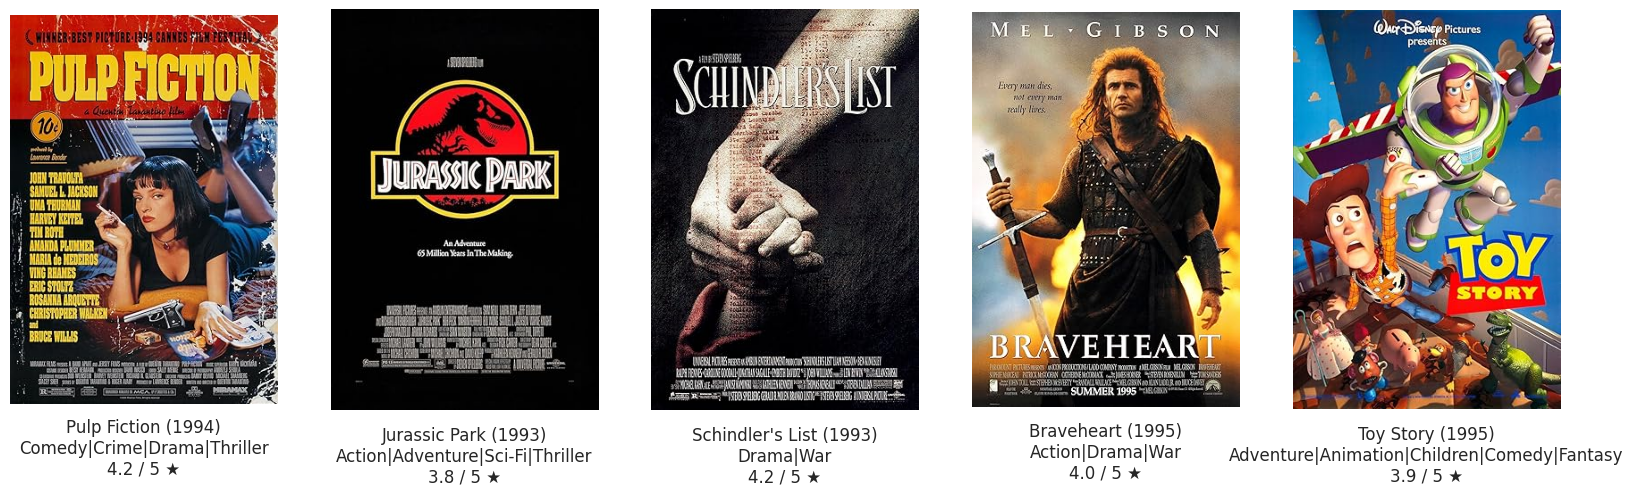

In [28]:
recommend(52, 5)